In [47]:
# %%writefile boosting_models.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
import datetime
import copy

from my_tools import get_bill_data

import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, mean_squared_error


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = get_bill_data()

------------------
Creating column 'labels'...


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


------------------
------------------
Data is from the 110th Congress (2007) to present
------------------


In [3]:
# non-numeric num_of_cosponsors: S. Rept. 110-184, TXT, All Actions
data = data[(data['num_of_cosponsors'] != 'S. Rept. 110-184') &
           (data['num_of_cosponsors'] != 'TXT') &
           (data['num_of_cosponsors'] != 'All Actions')]

In [4]:
data['num_of_cosponsors'] = data['num_of_cosponsors'].apply(pd.to_numeric)

In [13]:
# Second iteration removes num_of_cosponsors and bill_char_counts...
data_features = data.loc[:, [
#                           'congress_id', 
                          'num_of_cosponsors', 
                          'sponsor_party', 
                          'sponsor_state', 
                          'bill_char_counts', 
                          'intro_month', 
                          'session', 
                           'labels']]

In [77]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = [
#                                             'congress_id', 
                                            'intro_month', 
                                            'sponsor_party', 
                                            'sponsor_state', 
                                            'session'
                                                ], 
                           drop_first=True)

In [78]:
y = data_dumm.pop('labels').values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, 
                                                    stratify = y, 
                                                    random_state = 123)

In [79]:
def stage_score_plot(estimator, X_train, y_train, X_test, y_test):
    '''
        Parameters: estimator: GradientBoostingRegressor or AdaBoostRegressor
                    X_train: 2d numpy array
                    y_train: 1d numpy array
                    X_test: 2d numpy array
                    y_test: 1d numpy array

        Returns: A plot of the number of iterations vs the MSE for the model for
        both the training set and test set.
    '''
    estimator.fit(X_train, y_train)
    name = estimator.__class__.__name__.replace('Regressor', '')
    learn_rate = estimator.learning_rate
    # initialize 
    train_scores = np.zeros((estimator.n_estimators,), dtype=np.float64)
    test_scores = np.zeros((estimator.n_estimators,), dtype=np.float64)
    # Get train score from each boost
    for i, y_train_pred in enumerate(estimator.staged_predict(X_train)):
        train_scores[i] = mean_squared_error(y_train, y_train_pred)
    # Get test score from each boost
    for i, y_test_pred in enumerate(estimator.staged_predict(X_test)):
        test_scores[i] = mean_squared_error(y_test, y_test_pred)
    plt.plot(train_scores, alpha=.5, label="{0} Train - learning rate {1}".format(
                                                                name, learn_rate))
    plt.plot(test_scores, alpha=.5, label="{0} Test  - learning rate {1}".format(
                                                      name, learn_rate), ls='--')
    plt.title(name, fontsize=16, fontweight='bold')
    plt.ylabel('MSE', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

In [80]:
gb = GradientBoostingClassifier(learning_rate=.05, n_estimators=100, random_state=123)
gb_1 = GradientBoostingClassifier(learning_rate=.04, n_estimators=100, random_state=123)
gb_2 = GradientBoostingClassifier(learning_rate=.02, n_estimators=100, random_state=123)

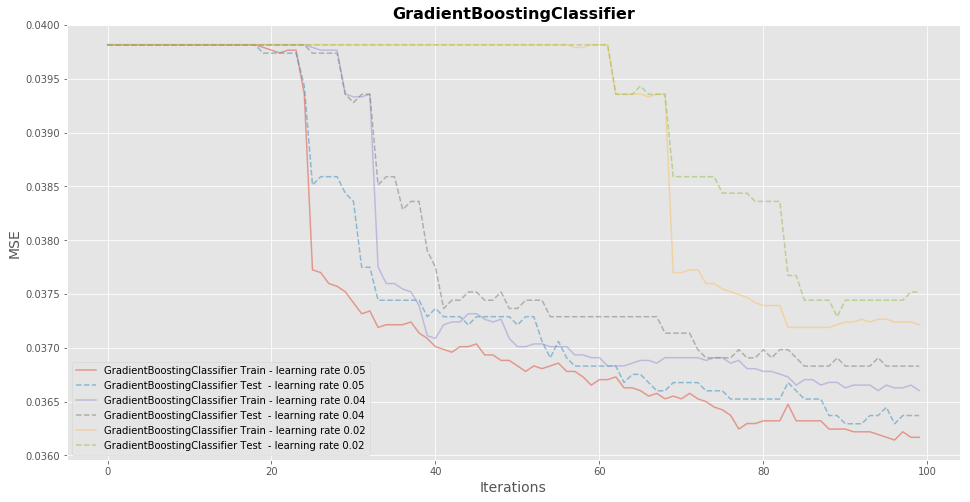

In [81]:
fig = plt.figure(figsize = (16, 8))
stage_score_plot(gb, X_train, y_train, X_test, y_test)
stage_score_plot(gb_1, X_train, y_train, X_test, y_test)
stage_score_plot(gb_2, X_train, y_train, X_test, y_test)
plt.legend()

In [82]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.05, 
                         n_estimators=100, 
                         random_state=123)

ada_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.04, 
                         n_estimators=100, 
                         random_state=123)

ada_3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.02, 
                         n_estimators=100, 
                         random_state=123)

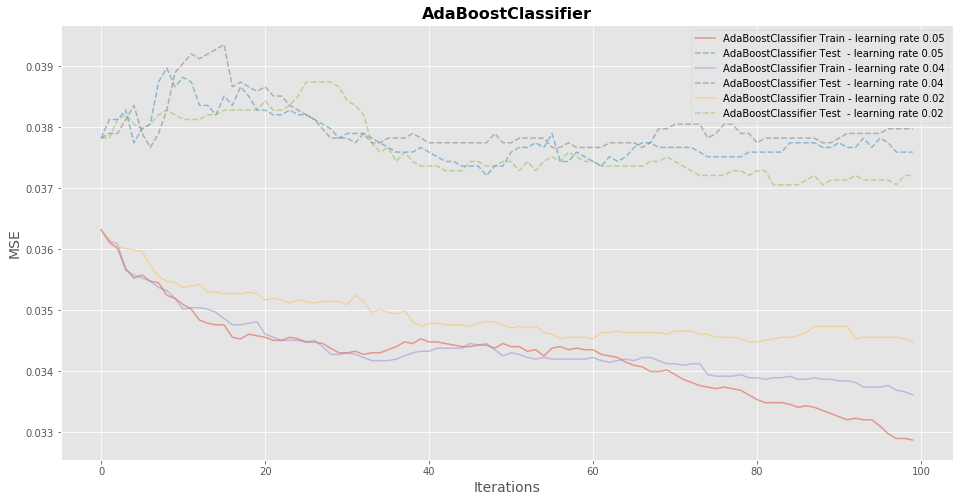

In [83]:
fig = plt.figure(figsize = (16, 8))
stage_score_plot(ada, X_train, y_train, X_test, y_test)
stage_score_plot(ada_2, X_train, y_train, X_test, y_test)
stage_score_plot(ada_3, X_train, y_train, X_test, y_test)
plt.legend()

In [84]:
# Gradient boosting giving us the lower MSE. At this point, it feels like I'm splitting hairs... 
# the difference in MSE is <.005

In [85]:
# after examination, going with a learning rate of .05
gb = GradientBoostingClassifier(learning_rate=.05, n_estimators=100, random_state=123)

In [86]:
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

print('----------------------')
print('----------------------')
print('Gradient Boosting Classifier')
print('----------------------')
print('Accuracy score:  {:.2f}'.format(accuracy_score(y_test, gb_y_pred)))
print('Precision score: {:.2f}'.format(precision_score(y_test, gb_y_pred)))
print('Recall score:    {:.2f}'.format(recall_score(y_test, gb_y_pred)))


----------------------
----------------------
Gradient Boosting Classifier
----------------------
Accuracy score:  0.96
Precision score: 0.69
Recall score:    0.16


In [87]:
gb_y_predict_proba = gb.predict_proba(X_test)

In [88]:
gb_y_predict_proba[:, 1]

array([0.03681157, 0.02743223, 0.02473705, ..., 0.02669435, 0.0311765 ,
       0.02539076])